In [52]:
import pandas as pd
import numpy as np
import logging
import warnings
import time
from IPython.core.interactiveshell import InteractiveShell

import plots
import data_loading_handling as sd

# Used to get multiple outputs per cell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings("ignore")  # ignore warnings in logs

logging.basicConfig(format='%(asctime)s - %(message)s',
                    level=logging.INFO)  # Logging configuration


In [53]:
popular_user = 0 # threshold to consider a user relevant
popular_movie = 0 # threshold to consider a movie popular
prune_by_user = False

logging.info('Loading Data Set')
headers = ['userId', 'movieId', 'movie_categoryId',
            'reviewId', 'movieRating', 'reviewDate']
columns = ['userId', 'movieId', 'movie_categoryId', 'movieRating']
data_set = pd.read_csv('Ciao-DVD-Datasets/movie-ratings_test.txt',
                           sep=',', names=headers, usecols=columns, dtype={'userId': 'int', 'movieId': 'int', 'movie_categoryId': 'str'})
data_set.shape

2020-05-09 21:25:00,431 - Loading Data Set


(69, 4)

In [54]:
# data_set information
print('data_set information')
num_users = data_set.userId.unique().shape[0]
num_items = data_set.movieId.unique().shape[0]
num_cat = data_set.movie_categoryId.unique().shape[0]
sparsity = 1 - len(data_set) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nCategories: {num_cat}\nRatings count: {len(data_set)}\nSparsity: {sparsity}\n")
data_set.info()
data_set.describe()

data_set information
Users: 20
Movies: 9
Categories: 4
Ratings count: 69
Sparsity: 0.6166666666666667

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   userId            69 non-null     int32 
 1   movieId           69 non-null     int32 
 2   movie_categoryId  69 non-null     object
 3   movieRating       69 non-null     int64 
dtypes: int32(2), int64(1), object(1)
memory usage: 1.7+ KB


,userId,movieId,movieRating
count,69.000000,69.000000,69.000000
mean,10.362319,4.362319,2.884058
std,6.034146,2.879803,1.419779
min,1.000000,1.000000,1.000000
25%,5.000000,2.000000,2.000000
50%,10.000000,4.000000,3.000000
75%,15.000000,7.000000,4.000000
max,20.000000,9.000000,5.000000


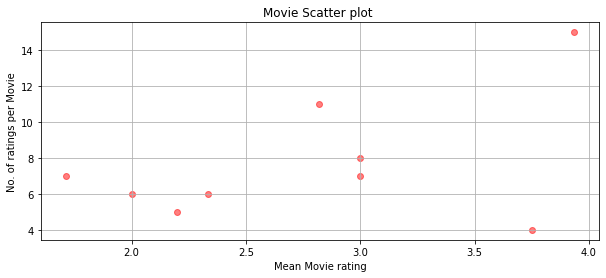

In [55]:
ratings = pd.DataFrame(data_set.groupby('movieId')['movieRating'].mean())
ratings['ratings_per_movie'] = data_set.groupby('movieId')['movieRating'].count()
settings = {'axisX': 'movieRating',
                'axisY': 'ratings_per_movie', 'topic': 'Movie'}
plots.scatterPlot(ratings, settings)
# ratings

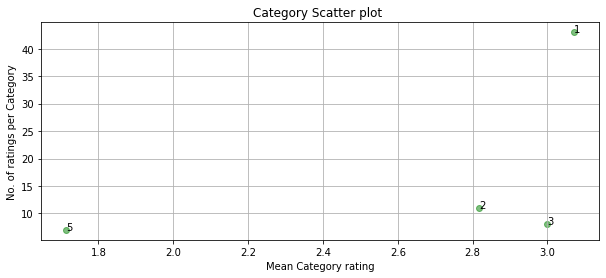

In [56]:
categories = pd.DataFrame(data_set.groupby('movie_categoryId')['movieRating'].mean())

# quantity of movies per categorie
categories['ratings_per_category'] = data_set.groupby('movie_categoryId')['movieId'].count()

# Plot number of movies per categories
plot_settings = {
    'axisX':'movieRating', 
    'axisY': 'ratings_per_category', 
    'topic': 'Category', 
    'color':'green',
    'labels': categories.index}
plots.scatterPlot(categories, plot_settings)

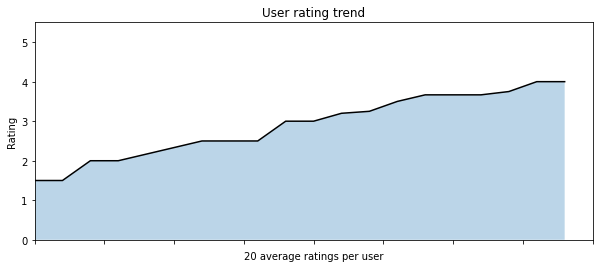

In [57]:
dataset_user_av = data_set.groupby("userId")['movieRating'].mean()
# Plot average rating per user
plots.avg_ratings_per_user(dataset_user_av)

In [58]:
if(prune_by_user):
    print("Pruned by User")
    dataset_user_count = data_set.groupby("userId")['movieRating'].count()
    unpopular_users = dataset_user_count[dataset_user_count < popular_user].index
    data_set.drop(data_set.loc[data_set['userId'].isin(unpopular_users)].index, inplace=True)
    data_set.shape
else:
    print("Pruned by Movie")
    unpopular_movies = ratings.loc[ratings['ratings_per_movie'] < popular_movie].index
    data_set.drop(data_set.loc[data_set['movieId'].isin(unpopular_movies)].index, inplace=True)
    data_set.shape

Pruned by Movie


(69, 4)

In [59]:
dense_data = data_set.pivot_table(index = 'userId', columns ='movieId', values = 'movieRating')
index_names = dense_data.index
columns_names = dense_data.columns
dense_data = dense_data.values
dense_data.shape

(20, 9)

In [60]:
train,test = sd.split_train_test_custom(dense_data,0.2)
train.shape
test.shape

(20, 9)

(20, 9)

## From here on starting the User to User CF with Pearson Correlation

In [61]:
user_avg = np.nanmean(train, axis=1)
user_avg = pd.DataFrame(user_avg, index = index_names)
user_avg.shape

(20, 1)

In [62]:
start = time.time()
pearson_corr = pd.DataFrame(train.T, columns=index_names).corr()
logging.info("Process done in: {0:.2f} seconds".format(
        time.time() - start))   

2020-05-09 21:25:01,933 - Process done in: 0.00 seconds


In [63]:
######## K-SIZE #######
k = 5  # Define the k neighbors
qou = int(index_names.shape[0])
neighbors = np.zeros((qou, k)).astype(int)
item=0
start = time.time()
for i in index_names:
    user_corr = pearson_corr[i].drop([i]).sort_values(ascending=False)    
    neighbors[item] = user_corr.iloc[:k].index.values
    item = item + 1
logging.info("Process done in: {0:.2f} seconds".format(
        time.time() - start))
neighbors.shape

2020-05-09 21:25:02,014 - Process done in: 0.03 seconds


(20, 5)

In [64]:
neighbors = pd.DataFrame(neighbors, index = index_names)
train = pd.DataFrame(train, index = index_names, columns=columns_names)

In [70]:
qom = int(columns_names.shape[0])
item=0
start = time.time()
predicted_matrix = np.empty((qou, qom))
predicted_matrix[:] = np.nan
for user in index_names:
    target_avg = user_avg.at[user,0]
    # target_avg
    k_neigbors = neighbors.loc[user]
    # k_neigbors
    k_correlation = pearson_corr.loc[user, k_neigbors].values
    # k_correlation

    k_ratings = train.loc[k_neigbors,:].values
    # k_ratings

    k_avg = user_avg.loc[k_neigbors].values
    # k_avg


    r_ru = np.subtract(k_ratings,k_avg)
    r_ru_corr = np.multiply(r_ru.T, k_correlation)
    nan_mask = np.isnan(r_ru_corr)
    r_ru_corr = np.ma.masked_array(r_ru_corr, nan_mask)

    numerator = np.sum(r_ru_corr, axis = 1)
    # numerator

    denominator = np.nansum(k_correlation)
    if(denominator > 0):
        predicted_matrix[item] = (numerator/ denominator) + target_avg
    item =  item + 1
logging.info("Process done in: {0:.5f} seconds".format(
        time.time() - start))

2020-05-09 21:25:29,791 - Process done in: 0.05000 seconds


In [66]:
bounds = (1, 5)  # max and min boundaries
predicted_matrix[predicted_matrix < bounds[0]] = bounds[0]
predicted_matrix[predicted_matrix > bounds[1]] = bounds[1]

In [67]:
logging.info('\nMetric Calculations RMSE')
start = time.time()
I = ~np.isnan(test) # indicator for missing values 
sqerror = abs(test - predicted_matrix) ** 2 # squared error array 
mse = np.nanmean(sqerror[I])  # mean squared error
np.sqrt(mse)
logging.info("Process done in: {0:.5f} seconds".format(
        time.time() - start))

2020-05-09 21:25:02,502 - 
Metric Calculations RMSE


nan

2020-05-09 21:25:02,506 - Process done in: 0.00300 seconds


In [68]:
logging.info('\nMetric Calculations MAE')
start = time.time()
I = ~np.isnan(test) # indicator for missing values 
error = abs(test - predicted_matrix) # error difference array 
np.nanmean(error[I])  # mean squared error
logging.info("Process done in: {0:.5f} seconds".format(
        time.time() - start))

2020-05-09 21:25:02,646 - 
Metric Calculations MAE


nan

2020-05-09 21:25:02,652 - Process done in: 0.00299 seconds
